## Loading data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import json

import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.utils import resample
from sklearn import svm

In [2]:
conn = sqlite3.connect('sqlite.db')
df_exec = pd.read_sql_query("SELECT * FROM 'exec';", conn)

In [3]:
display(df_exec.head())

,ts,exe,pid,ppid,path,docker,depth,rates
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}"
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}"
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}"
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}"
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}"


In [4]:
df_exec['rates1'] = np.nan
df_exec['rates5'] = np.nan
for it in enumerate(df_exec.rates.values):
    Dic = json.loads((it[1]))
    df_exec.set_value(it[0], 'rates1', Dic["1"])
    df_exec.set_value(it[0], 'rates5', Dic["5"])
    
df_exec = df_exec.sort_values('ts').reset_index(drop=True)    
   

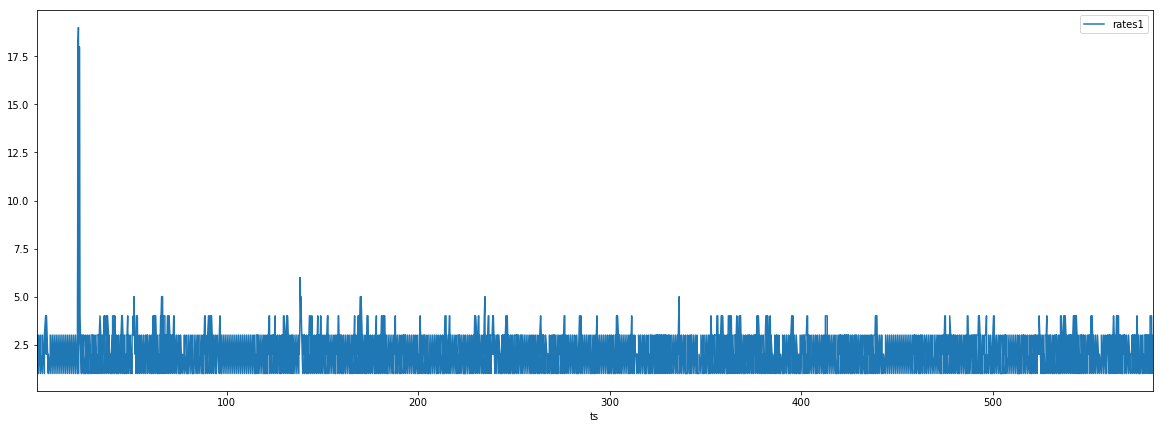

In [5]:
tm = df_exec[['ts','rates1']].set_index('ts')
tm.plot(figsize=(20,7))
plt.show()

## Data Statistics

In [6]:
conn = sqlite3.connect('sqlite.db')
df_tcplife = pd.read_sql_query("SELECT * FROM 'tcplife';", conn)

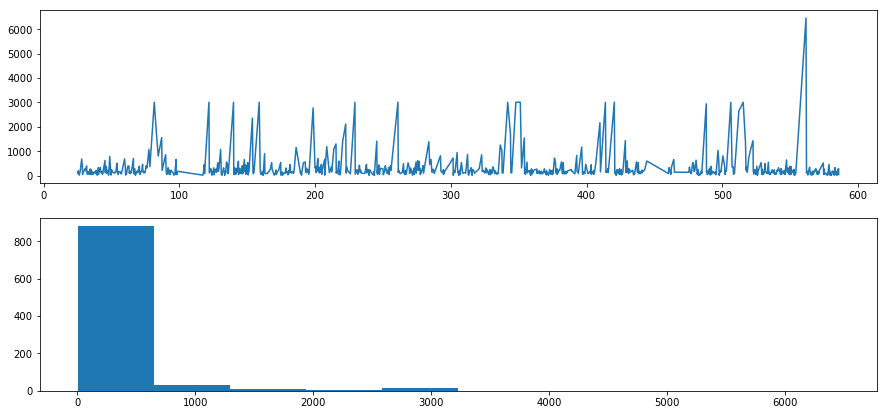

,ts,pid,rx,tx,dur,prediction,predquality
count,944.000000,944.000000,944.000000,944.0,944.000000,944.000000,944.000000
mean,307.715209,29928.452331,61.332627,0.0,261.219121,-15.492141,0.875000
std,171.971029,751.111665,69.228605,0.0,479.331879,23.434887,0.330894
min,25.147065,28668.000000,0.000000,0.0,5.040000,-569.245187,0.000000
25%,157.886505,29267.750000,4.000000,0.0,85.512500,-13.940197,1.000000
50%,307.397860,29935.500000,26.000000,0.0,144.650000,-11.497844,1.000000
75%,462.115531,30601.000000,115.000000,0.0,226.797500,-10.481379,1.000000
max,585.672974,31149.000000,540.000000,0.0,6454.020000,8.375431,1.000000


In [7]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,7))
ax1.plot(df_tcplife.ts,df_tcplife.dur)
ax2.hist(df_tcplife.dur,bins = 10)
plt.show()

df_tcplife.describe()

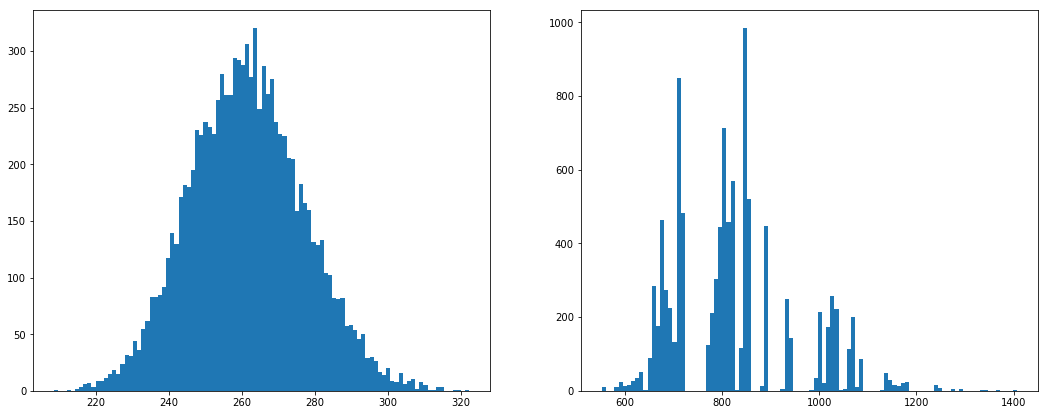

In [11]:
np.percentile(np.array(df_tcplife.dur),99)

#use bootstrapping to approximate the real distribution of "dur"
bootstrapping_dist = np.zeros(10000)
tile_dist = np.zeros(10000)
for i in range(10000):
    X = resample(np.array(df_tcplife.dur), replace=True)
    bootstrapping_dist[i] = np.mean(X)
    tile_dist[i] = np.percentile(X,95)
    

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,7)) 
ax1.hist(bootstrapping_dist,bins=100)
#ax1.title('bootstrapping of mean')
ax2.hist(tile_dist,bins=100)
#ax2.title('bootstrapping of 99-percentile')
plt.show()

In [12]:
#get the indexes of outliers
thres = np.percentile(tile_dist,95)
df_outliers = df_tcplife.loc[df_tcplife['dur']>thres]

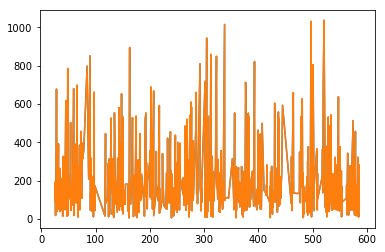

In [17]:
df_tcplife.loc[(df_tcplife['dur']<thres)].shape
plt.plot(df_tcplife.loc[(df_tcplife['dur']<thres)].ts,df_tcplife.loc[(df_tcplife['dur']<thres)].dur)
plt.show()

## Data Modeling

In [ ]:
#X = df_tcplife.ts.values
#y = df_tcplife.dur.values

#clf = svm.SVR()
#clf.fit(X, y)
from pandas.tools.plotting import autocorrelation_plot

plt.figure(figsize=(20,8))
autocorrelation_plot(df_tcplife.dur.values)
plt.show()

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
x = np.array(df_tcplife.ts.values)
print(x.shape)
x_train = x[:800].reshape(1,800)
#x_test = x[801:].reshape(1,944-801)
X = x.reshape(1,944)
Y = np.array(df_tcplife.dur.values)
print(Y.shape)
y_train = Y[:800].reshape(1,800)
#y_test = Y[801:].reshape(1,944-801)
y=Y.reshape(1,944)
# need to adjust alpha according to the data quality
gp = GaussianProcessRegressor(kernel=kernel, alpha=3,\
                              n_restarts_optimizer=10)
gp.fit(x_train, y_train)
y_pred, sigma = gp.predict(X, return_std=True)
y_pred = np.array(y_pred)
fig = plt.figure()
plt.plot(x, Y, 'r:',label='true data')
plt.plot(x, y_pred.flatten(), 'b-',label='predicted data')
plt.legend(loc='best')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import warnings

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python import SKCompat
from sklearn.metrics import mean_squared_error

#import lstm_predictior 
from lstm_predictor import generate_data, lstm_model

warnings.filterwarnings("ignore")

LOG_DIR = 'resources/logs/'
TIMESTEPS = 1
RNN_LAYERS = [{'num_units': 400}]
DENSE_LAYERS = None
TRAINING_STEPS = 500
PRINT_STEPS = TRAINING_STEPS # / 10
BATCH_SIZE = 100

X = {'train':df_tcplife.ts.values[:700],'val':df_tcplife.ts.values[700:],\
     'test':np.linspace(df_tcplife.ts.values[-1], 1, df_tcplife.ts.values[-1]+20, dtype=np.float32)}
y = {'train':df_tcplife.dur.values[:700],'val':df_tcplife.dur.values[700:]}

#X, y = generate_data(df_tcplife.ts.values, df_tcplife.dur.values, TIMESTEPS, seperate=False)

In [ ]:
#validation_monitor = learn.monitors.ValidationMonitor(df_tcplife.ts.values[800:], df_tcplife.dur.values[800:],
#                                                      every_n_steps=PRINT_STEPS,
#                                                      early_stopping_rounds=1000)
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'])

In [ ]:
#regressor.fit(df_tcplife.ts.values[:800], df_tcplife.dur.values[:800])
SKCompat(regressor.fit(X['train'], y['train'],
              monitors=[validation_monitor],
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS))